# Extract the MS2 scan and do signature neutral loss search
- run multiple files
- need to define a precursor target list & scan range (let's just try to do more inclusive one)

In [65]:
# !pip install pymzml
%matplotlib inline

In [66]:
import numpy as np
from matplotlib import pyplot as plt
import pymzml
import os
import pandas as pd
import sys

In [67]:
sys.path.append('../pyutils/')  # add the second parent directory
from searchMS2 import *

In [68]:
# spectrum.selected_precursors
# [{'mz': 417.320373535156, 'charge': 1, 'precursor id': '2'}]

In [69]:
dir_path = "../../../../raw_mzML/pooled_sample_DDA/mzML/RPneg/"
files_and_dirs = os.listdir(dir_path)

# Get the full path for each file/directory in the list
infiles = [os.path.join(dir_path, file) for file in files_and_dirs]

In [70]:
exps = []
for infile in infiles:
    exps.append(pymzml.run.Reader(infile))

[Warning] Not index found and build_index_from_scratch is False


## Basic information - using the first instance

In [71]:
exp = pymzml.run.Reader(infiles[0])

[Warning] Not index found and build_index_from_scratch is False


In [72]:
# How many spectra
exp.get_spectrum_count()

6830

In [73]:
exp.ms_precisions # ms-level 1: ppm 5; ms-level 2: ppm 20?

{None: 0.0001, 0: 0.0001, 1: 5e-06, 2: 2e-05}

### Small benchmarking if needed

In [74]:
# collect_spec = []
# ii = 0 
# for spec in exp:
#     if spec.ms_level == 2: 
#         if (2446 < ii < 3013) & (834 < spec.selected_precursors[0]['mz'] < 835):
#             collect_spec.append(spec)
#         ii += 1

# plot_spectra(collect_spec)

##### summary
- a probably 12 min run (720 secs) for 4008 scans
- 0.17964 second/scan

## Load target list

In [75]:
df_sel = pd.read_csv("./data/input/features_matched2targetPS_M-Honly.csv")

In [76]:
df_sel.head(10)

,FTID,formula,neutral_mass,short_name
0,F9996,C43H76NO10P,797.520687,PS 37:4
1,F9994,C43H76NO10P,797.520687,PS 37:4
2,F9995,C43H76NO10P,797.520687,PS 37:4
3,F9997,C43H76NO10P,797.520687,PS 37:4
4,F14243,C49H84NO10P,877.583287,PS 43:6
5,F14242,C49H84NO10P,877.583287,PS 43:6
6,F5440,C26H50NO10P,567.317237,PS 20:0
7,F5441,C26H50NO10P,567.317237,PS 20:0
8,F13352,C42H80NO10P,789.551987,PS 36:1
9,F13353,C42H80NO10P,789.551987,PS 36:1


In [77]:
FTIDs = df_sel['FTID'].tolist()

In [78]:
df_feat_annot = pd.read_csv("../../../../asari-output-RPneg/output_asari_project_31312361/Feature_annotation.tsv",
                           sep = '\t', index_col=0)

In [79]:
# Select the desired rows and columns from the DataFrame
subset = df_feat_annot.loc[FTIDs, ['mz', 'rtime', 'apex(scan number)']]
# drop duplicates
subset_dd = subset.drop_duplicates() 
# Convert the subset to a dictionary with row-wise orientation
target_dict = subset_dd.to_dict(orient='index')

In [80]:
list(target_dict.items())[0]

('F9996', {'mz': 796.5134125, 'rtime': 247.5722656, 'apex(scan number)': 1119})

## Do a pre-filtering, mostly those that fall outside rtime 200-400 seconds, probably won't be PS

In [81]:
target_dict_upd = {}
for k,v in target_dict.items():
    if 200<v['rtime']<450:
        target_dict_upd.update({k:v})

In [82]:
len(target_dict)

277

In [83]:
len(target_dict_upd)

217

In [84]:
# # testing
# target_dict_test = {k:v for k,v in target_dict.items() if k == "F13469"}
# target_dict_test

## get potential precursor from multiple files

In [85]:
target_dict_test

{'F13469': {'mz': 834.5291901,
  'rtime': 301.5134942,
  'apex(scan number)': 1375}}

In [86]:
res_dict = {}
for exp in exps:
    for k,v in target_dict_upd.items(): # target_dict_test
        spectra = get_potental_precursor_from_exp_filtbyRt(exp, 
                              min_rt_sec = v['rtime']-100, 
                              max_rt_sec = v['rtime']+100, 
                              min_mz = v['mz']-1, 
                              max_mz = v['mz']+1, 
                              ms_level=2)
        res_dict[k] = spectra

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_inde

In [87]:
res_dict_clean = {k:v for k,v in res_dict.items() if len(v) != 0}

In [88]:
res_dict_clean

{'F9996': [<__main__.Spectrum object with native ID 3064 at 0x7feb419fadc0>,
  <__main__.Spectrum object with native ID 3100 at 0x7feb3d7657f0>,
  <__main__.Spectrum object with native ID 3105 at 0x7feb2a44aac0>,
  <__main__.Spectrum object with native ID 3130 at 0x7feb2a44a550>,
  <__main__.Spectrum object with native ID 3142 at 0x7feb2a44ae50>,
  <__main__.Spectrum object with native ID 3169 at 0x7feb2a44ad30>,
  <__main__.Spectrum object with native ID 3180 at 0x7feb419fab50>,
  <__main__.Spectrum object with native ID 3208 at 0x7feb43173910>,
  <__main__.Spectrum object with native ID 3229 at 0x7feb2a44abb0>,
  <__main__.Spectrum object with native ID 3247 at 0x7feb2a44a0d0>,
  <__main__.Spectrum object with native ID 3287 at 0x7feb2a44a100>,
  <__main__.Spectrum object with native ID 3327 at 0x7feb2a44a730>],
 'F9995': [<__main__.Spectrum object with native ID 3064 at 0x7feb2a44a130>,
  <__main__.Spectrum object with native ID 3100 at 0x7feb2a44a400>,
  <__main__.Spectrum object w

In [89]:
# this function only works for situation where you look at charge state = 1
def search_NL(spectra,
              NL_mz = 87.03124,
              ppm = 50):
    res_data = []

    for spec in spectra:
        selected_precursor_mz = spec.selected_precursors[0]['mz'] # this m/z will not be exactly the precursor m/z
        sel_mz = [mz for mz in spec.mz if abs(mz - selected_precursor_mz) < np.ceil(NL_mz)]

        for mz in sel_mz:
            calc_ppm = abs(((selected_precursor_mz - mz) - NL_mz)*1000000/NL_mz)
            if calc_ppm < ppm:
                print(calc_ppm)
                res_data.append(spec)
                break
    return res_data

In [90]:
NL_res_dict = {}
for FTID, spectra in res_dict_clean.items():
    NL_res_dict.update({FTID: search_NL(spectra)})

11.335728417266278
20.452650464972972
21.855253855119155
11.335728417266278
20.452650464972972
21.855253855119155
16.946141983076124
14.140935202783753
14.842236899163122
12.738331807412463
16.946141983076124
14.140935202783753
14.842236899163122
12.738331807412463
16.946141983076124
14.140935202783753
14.842236899163122
12.738331807412463
34.47868439778546
0.11490127258381946
31.673477604430325
10.634426715661803


In [91]:
NL_res_dict_clean = {k:v for k,v in NL_res_dict.items() if len(v) != 0}

In [92]:
NL_res_dict_clean

{'F11500': [<__main__.Spectrum object with native ID 2965 at 0x7feb419fa040>,
  <__main__.Spectrum object with native ID 3001 at 0x7feb419d2fa0>,
  <__main__.Spectrum object with native ID 3037 at 0x7feb41845910>],
 'F11501': [<__main__.Spectrum object with native ID 2965 at 0x7feb431294c0>,
  <__main__.Spectrum object with native ID 3001 at 0x7feb2a455be0>,
  <__main__.Spectrum object with native ID 3037 at 0x7feb419d2e50>],
 'F13468': [<__main__.Spectrum object with native ID 2869 at 0x7feb431291c0>,
  <__main__.Spectrum object with native ID 2905 at 0x7feb2a44ad90>,
  <__main__.Spectrum object with native ID 2937 at 0x7feb2a44a190>,
  <__main__.Spectrum object with native ID 3013 at 0x7feb2a44aa90>],
 'F13469': [<__main__.Spectrum object with native ID 2869 at 0x7feb2a3dff10>,
  <__main__.Spectrum object with native ID 2905 at 0x7feb2a4557f0>,
  <__main__.Spectrum object with native ID 2937 at 0x7feb2a4556a0>,
  <__main__.Spectrum object with native ID 3013 at 0x7feb2a44aee0>],
 'F1

# plot accordingly

In [93]:
NL_res_dict_clean.keys()

dict_keys(['F11500', 'F11501', 'F13468', 'F13469', 'F13470', 'F12087'])

In [94]:
df_sel.index = df_sel['FTID']

In [95]:
df_sel.columns[0:6]

Index(['FTID', 'formula', 'neutral_mass', 'short_name'], dtype='object')

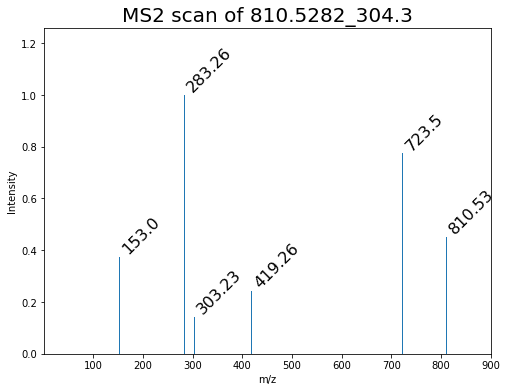

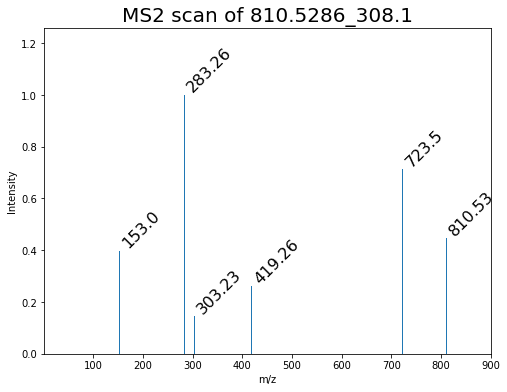

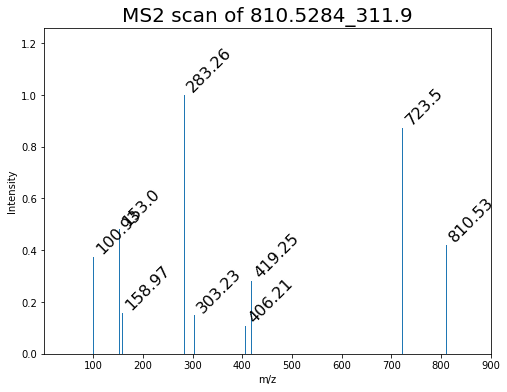

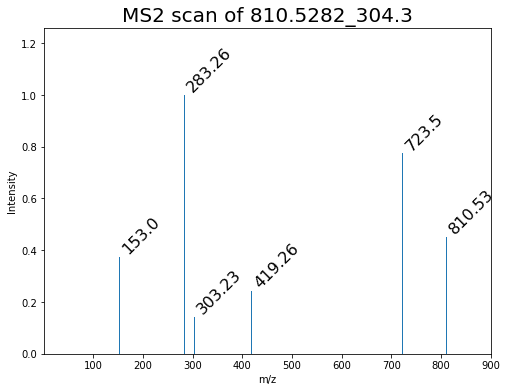

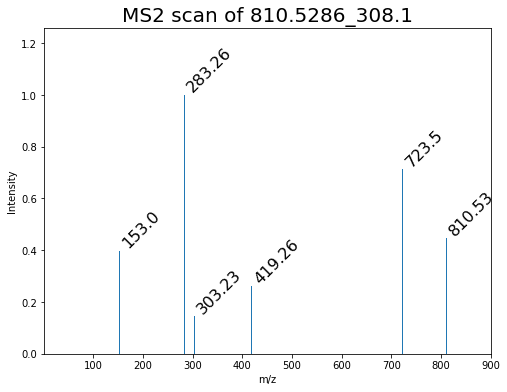

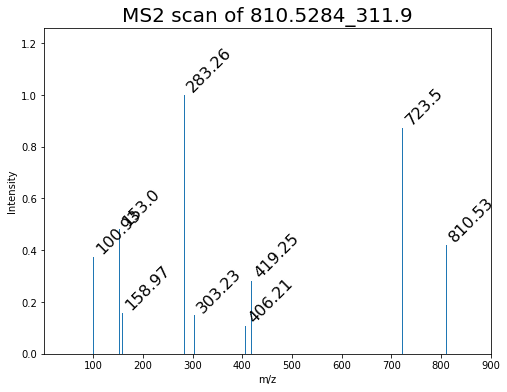

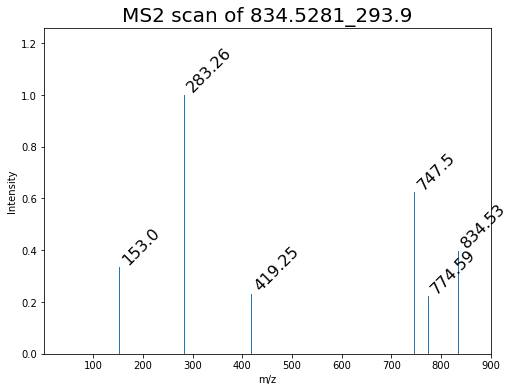

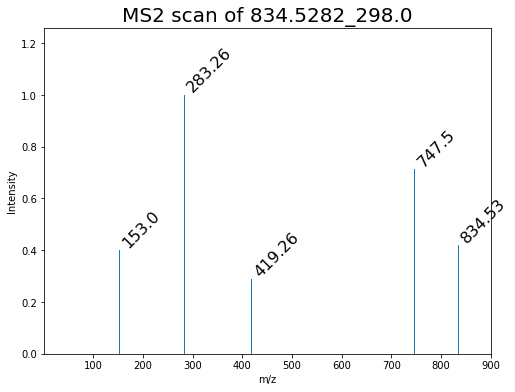

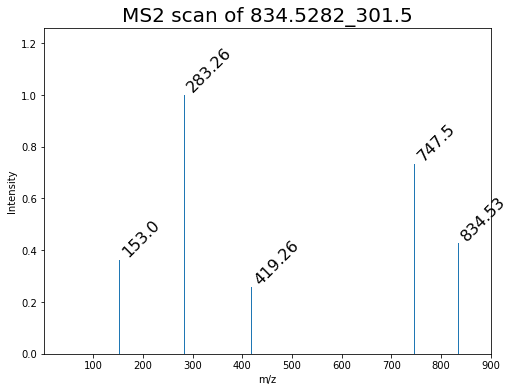

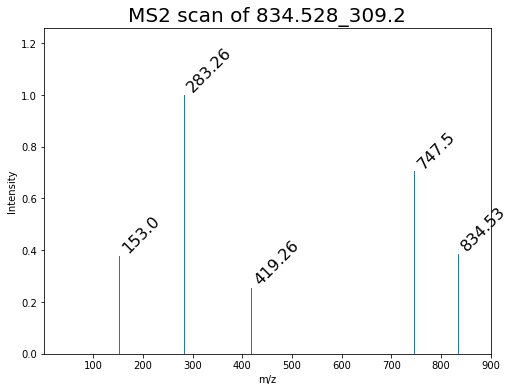

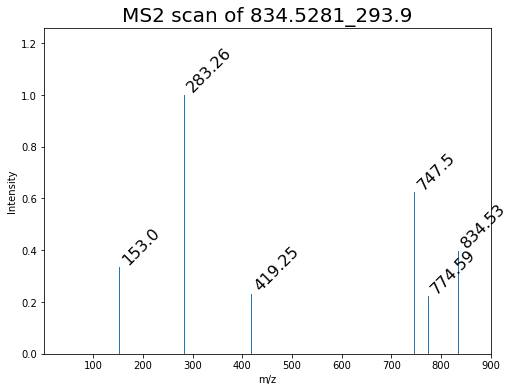

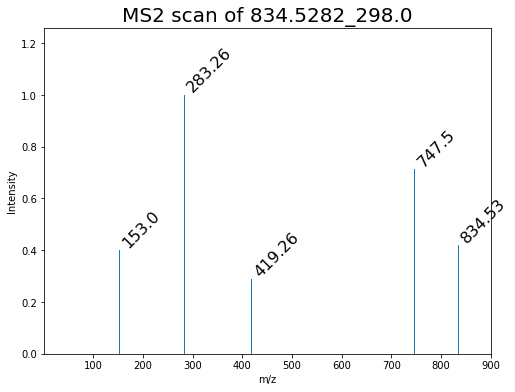

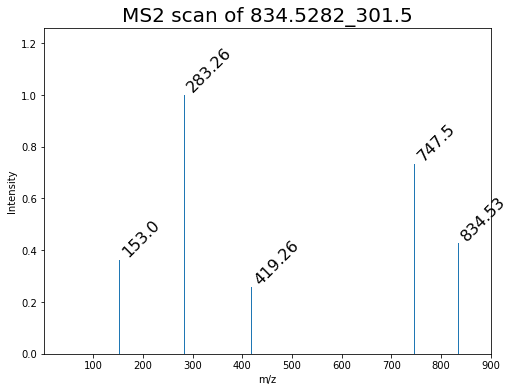

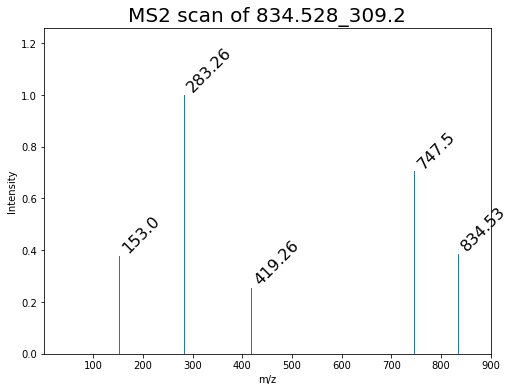

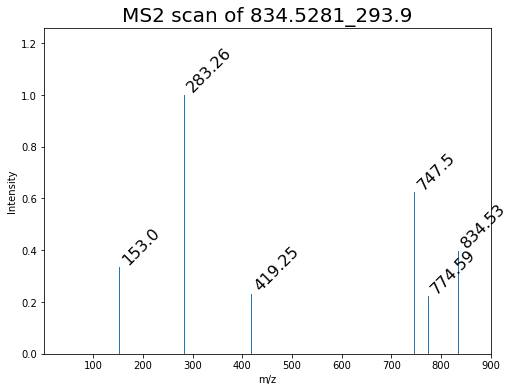

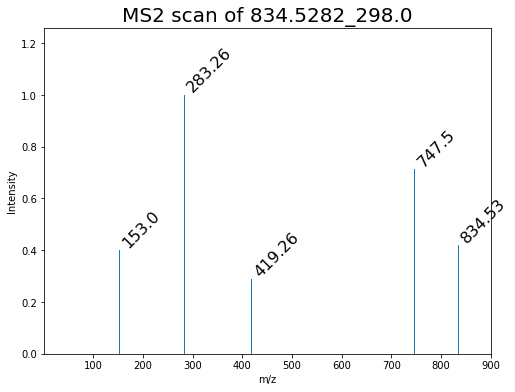

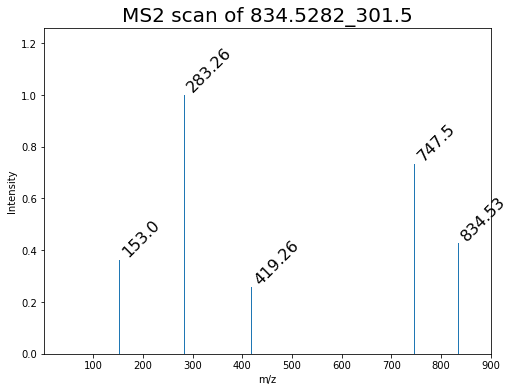

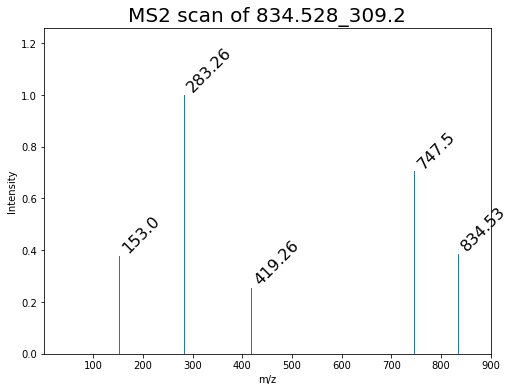

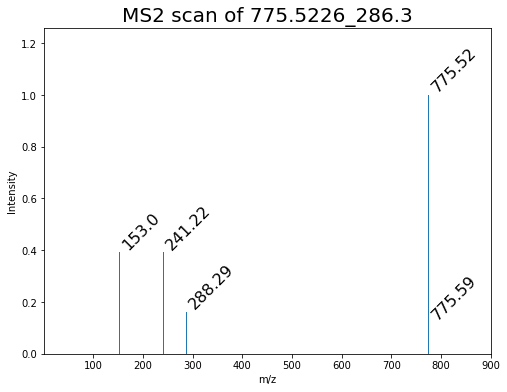

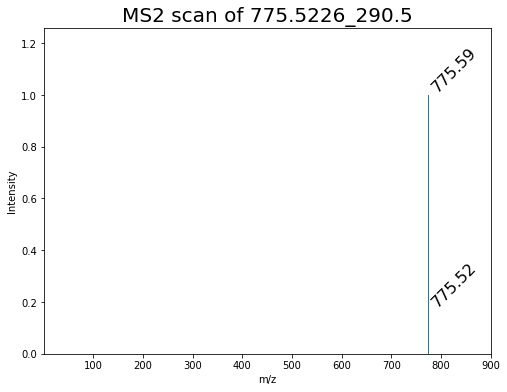

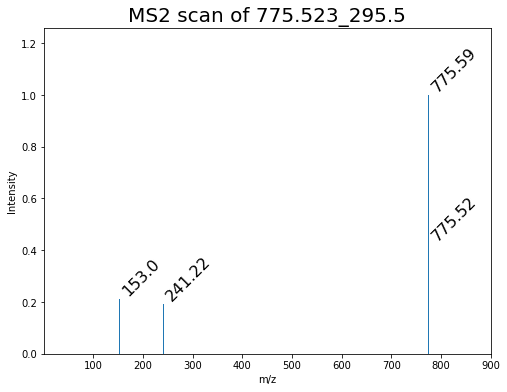

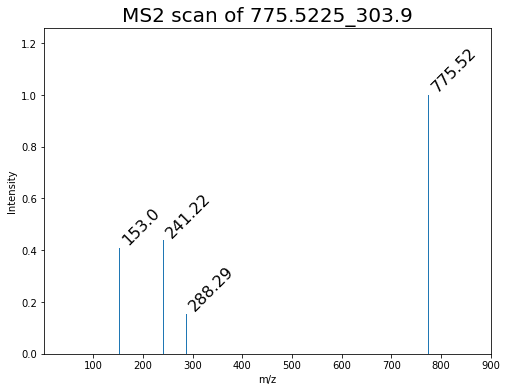

In [96]:
for FTID in NL_res_dict_clean.keys():
    plot_spectra(spectra = NL_res_dict_clean[FTID], 
                 save_figure=True,
                 output_path=f"./data/output_/{FTID}_{df_sel.loc[FTID,'short_name']}/",
                 label = f"{FTID}_{df_sel.loc[FTID,'short_name']}"
                 )